tool_list =  
(
    [add, multiply, search_tool, retriever_tool]  
     + gmail_tool_list + loaded_tool_list
)

* from langgraph.checkpoint.memory import MemorySaver
* DuckDuckGoSearchRun
* from langchain.agents import load_tools
* create_retriever_tool
* ToolNode

### make tools

In [1]:
# web 검색 tool

from langchain_community.tools import DuckDuckGoSearchResults

search_tool = DuckDuckGoSearchResults()

In [2]:
# 논문 검색 tool

from langchain.agents import load_tools

loaded_tool_list = load_tools(['arxiv'])

In [3]:
# 부동산법 retirever tool

from langchain_upstage import UpstageEmbeddings
from langchain_pinecone import PineconeVectorStore
from langchain_core.tools.retriever import create_retriever_tool

embedding = UpstageEmbeddings(model="embedding-query")

vector_store = PineconeVectorStore(
    embedding=embedding,
    index_name='real-estate'
    )

retriever = vector_store.as_retriever(search_kwargs={'k': 3})

retriever_tool = create_retriever_tool(
    retriever=retriever,
    name="real_estate_tax_retriever",
    description="Contains information about real estate tax up to December 2024"
)

In [4]:
# 더하기 & 곱하기 tool

from langchain_core.tools import tool

@tool
def add(a: int, b: int):
    """a와 b를 더하는 함수"""
    return a + b

@ tool
def multiply(a: int, b: int):
    """a와 b를 곱하는 함수"""
    return a * b

In [5]:
# gmail tool
from langchain_google_community import GmailToolkit

from langchain_google_community.gmail.utils import (
    build_resource_service,
    get_gmail_credentials,
)

# Can review scopes here https://developers.google.com/gmail/api/auth/scopes
# For instance, readonly scope is 'https://www.googleapis.com/auth/gmail.readonly'
credentials = get_gmail_credentials( # -> 자격
    token_file="google/token.json",
    scopes=["https://mail.google.com/"],
    client_secrets_file="google/credentials.json",
)
api_resource = build_resource_service(credentials=credentials)
gmail_toolkit = GmailToolkit(api_resource=api_resource)
gmail_tool_list = gmail_toolkit.get_tools()

In [6]:
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI

tool_list = [search_tool, add, multiply, retriever_tool] + gmail_tool_list + loaded_tool_list

llm = ChatOpenAI(model="gpt-4o")

llm_with_tools = llm.bind_tools(tool_list)

tool_node = ToolNode(tool_list)

### make state

In [7]:
from langgraph.graph import StateGraph, MessagesState

class State(MessagesState):
    summary: str

graph_builder = StateGraph(State)

### make node

In [8]:
from langchain_core.messages import SystemMessage

def agent(state: State) -> State:
    """llm_with_tools로 생성한 ai_message를 return하는 노드"""

    messages = state["messages"]
    summary = state["summary"]

    if summary != "":
        messages = [SystemMessage(content=f"""이전 메세지의 요약을 참고해주세요. 
        이전 메세지: {summary}""")] + messages

    resposne = llm_with_tools.invoke(messages)

    return {"messages": resposne}

In [9]:
from langgraph.types import interrupt, Command
from typing import Literal

def human_review(state: State) -> Command[Literal["agent", "tool_node"]]:

    messages = state["messages"]
    last_messages = messages[-1]

    tool_call = last_messages.tool_calls[-1]

    human_review = interrupt(
        {"question": "이렇게 진행하면 될까요?", "tool_calls": tool_call}
    )

    review_action = human_review["action"]
    review_data = human_review.get("data", None)

    if review_action == "continue":
        return Command(goto="tool_node")

    if review_action == "update_args":
        # -> tool은 마음에 들지만 args가 마음에 안드는 경우
        # aimessage를 update해서 toolnode로 보낸다
        updated_message = {
            "content": last_messages.content,
            "role": "ai",
            "id": last_messages.id,
            "tool_calls": [
                {
                'name': tool_call['name'],
                'args': review_data,
                'id': tool_call['id']
                }
            ]
        }        
        return Command(goto="tool_node", update={"messages": [updated_message]})

    if review_action == "update_tool":
        # -> tool이 마음에 안드는 경우
        # -> tool_call_id을 바꾸지는 못하고 content에 특정 tool을 사용해라 명시
        # -> 다시 agent로 보내어서 aimessage 생성(최종)
        updated_message = {
            "content": review_data,
            "name": tool_call["name"],
            "tool_call_id": tool_call['id'],
            "role": "tool"
        }
        return Command(goto="agent", update={"messages": [updated_message]})

In [10]:
def summarize_message(state: State):

    messages = state['messages']
    summary = state['summary']

    summarize_prompt = f"""
    다음 메세지들을 요약해주세요. 메세지 목록:{messages}
    """

    if summary != "":
        summarize_prompt = f"""
        이전 메세지의 요약을 포함하여 다음 메세지들을 요약해주세요.
        이전 메세지 요약:{summary},
        다음 메세지:{messages}
        """

    response = llm.invoke(summarize_prompt)

    return {"summary": response.content}

In [11]:
from langchain_core.messages import RemoveMessage

def delete_message(state: State):

    messages = state["messages"]

    response = [RemoveMessage(id=message.id) for message in messages[:-3]]

    return {"messages": response}

In [12]:
from typing_extensions import Literal

def should_continue(state: State) -> Literal['human_review', 'summarize_message']:

    messages = state["messages"]
    last_messages = messages[-1]

    if last_messages.tool_calls:
        return "human_review"

    return "summarize_message"

### make graph

In [13]:
from langgraph import graph


graph_builder.add_node("tool_node", tool_node)
graph_builder.add_node("agent", agent)
graph_builder.add_node(summarize_message)
graph_builder.add_node(human_review)
graph_builder.add_node(delete_message)

In [14]:
from langgraph import graph
from langgraph.graph import START, END 

graph_builder.add_edge(START, "agent")
graph_builder.add_conditional_edges("agent", should_continue, 
{
    "human_review": "human_review", 
    "summarize_message": "summarize_message"
    }
)
graph_builder.add_edge("tool_node", "agent")
graph_builder.add_edge("summarize_message", "delete_message")
graph_builder.add_edge("delete_message", END)

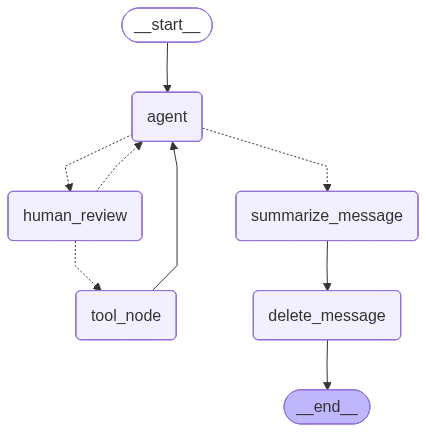

In [15]:
from langgraph.checkpoint.memory import MemorySaver 

checkpointer = MemorySaver()

graph_builder.compile(checkpointer=checkpointer)

In [16]:
graph = graph_builder.compile(checkpointer=checkpointer)

In [17]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "llm_paper"}}

query = "LLM Survey 논문의 내용을 검색해서 요약해주세요"

initial_state = {"messages": [HumanMessage(query)], "summary": ""}

for chunk in graph.stream(
    config=config,
    input=initial_state,
    stream_mode="values"
):
    
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

LLM Survey 논문의 내용을 검색해서 요약해주세요
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_JZLUfDP98mb9SK11A03US3bk)
 Call ID: call_JZLUfDP98mb9SK11A03US3bk
  Args:
    query: LLM Survey


In [ ]:
for chunk in graph.stream(

    Command(resume={"action": "continue", "data": ""}), config, stream_mode="updates"):
    print(chunk)

{'human_review': None}
{'tool_node': {'messages': [ToolMessage(content="Published: 2025-04-13\nTitle: From LLMs to LLM-based Agents for Software Engineering: A Survey of Current, Challenges and Future\nAuthors: Haolin Jin, Linghan Huang, Haipeng Cai, Jun Yan, Bo Li, Huaming Chen\nSummary: With the rise of large language models (LLMs), researchers are increasingly\nexploring their applications in var ious vertical domains, such as software\nengineering. LLMs have achieved remarkable success in areas including code\ngeneration and vulnerability detection. However, they also exhibit numerous\nlimitations and shortcomings. LLM-based agents, a novel tech nology with the\npotential for Artificial General Intelligence (AGI), combine LLMs as the core\nfor decision-making and action-taking, addressing some of the inherent\nlimitations of LLMs such as lack of autonomy and self-improvement. Despite\nnumerous studies and surveys exploring the possibility of using LLMs in\nsoftware engineering, it 